DQN With other test less epsoied 

In [1]:
import os
import random
import gym
import pylab
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam ,RMSprop

C:\Users\Mohammed\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\Mohammed\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Mohammed\anaconda3\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


In [2]:
def Model(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    # Hidden layer with 64 nodes
    X = Dense(32, activation="relu", kernel_initializer='he_uniform')(X) 
    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)
    model = Model(inputs = X_input, outputs = X)
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    model.summary()
    return model

-------------DQN------------
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_10 (Dense)            (None, 512)               2560      
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 2)                 66        
                                                                 
Total params: 152,482
Trainabl

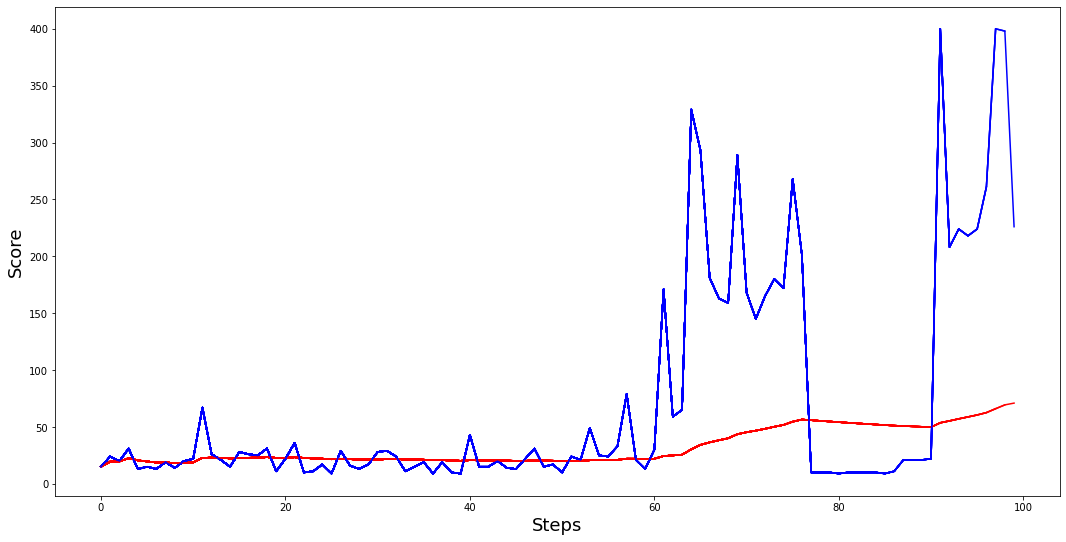

In [4]:
class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        self.env._max_episode_steps = 400 #4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 100 #1000
        self.memory = deque(maxlen=2000)
        
        self.gamma         = 0.95    # discount rate
        self.epsilon       = 1.0  # exploration rate
        self.epsilon_min   = 0.01
        self.epsilon_decay = 0.999
        self.batch_size    = 32
        self.train_start   = 900
        # we need to test DQN so we set Double to false 
        self.ddqn = False
        self.Soft_Update = False

        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        self.scores, self.episodes, self.average = [], [], []
        
        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"DQN_"+self.env_name+".h5")
        
        # create main model
        self.model = Model(input_shape=(self.state_size,), action_space = self.action_size)
        self.target_model = Model(input_shape=(self.state_size,), action_space = self.action_size)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(self.batch_size, self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        if self.ddqn:
            dqn = 'DDQN_'
        if self.Soft_Update:
            softupdate = '_soft'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every step update target model
                    self.update_target_model()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                     
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, self.epsilon, average))
                    if i == self.env._max_episode_steps:
#                         print("Saving trained model as cartpole-ddqn.h5")
                        print("Saving trained model as cartpole-dqn.h5")
                        self.save("cartpole-dqn.h5")
                        break
                self.replay()

    def test(self):
#         self.load("cartpole-ddqn.h5")
        self.load("cartpole-dqn.h5")

        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

# Testing for DQN Model that was traind on  1000
and we can test with new model as well

In [5]:
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
#     agent.run()
    agent.test()

-------------DQN------------
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_20 (Dense)            (None, 512)               2560      
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 2)                 66        
                                                                 
Total params: 152,482
Trainabl